# IMDB Sentiment Classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.datasets import imdb
from keras.layers import Dense, AlphaDropout, BatchNormalization, GRU, Embedding
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [46]:
data = pd.read_csv('training.csv')

In [47]:
data.head()

,id,category,text
0,959,0,5573 1189 4017 1207 4768 8542 17 1189 5085 5773
1,994,0,6315 7507 6700 4742 1944 2692 3647 4413 6700
2,995,0,5015 8067 5335 1615 7957 5773
3,996,0,2925 7199 1994 4647 7455 5773 4518 2734 2807 8...
4,997,0,7136 1207 6781 237 4971 3669 6193


In [48]:
data.drop(columns='id', inplace=True)

# Get the length of each tokenized sentence

In [50]:
x_train = [el.split(' ') for el in data['text']]
num_tokens = [len(tokens) for tokens in x_train]

In [51]:
lengths = pd.DataFrame(data=num_tokens)

In [52]:
lengths.head()

,0
0,10
1,9
2,6
3,24
4,7


# Let's look at some statistical information of the length of the tokens

In [53]:
lengths.describe()

,0
count,3464.000000
mean,18.840069
std,107.460556
min,1.000000
25%,8.000000
50%,13.000000
75%,23.000000
max,6290.000000


# Looks like 23 tokens per sentence can cover 100% information for 75% of the data set
## We have some outliers that is causing the standard deviation to be very high
### Let us plot with seq_lim bins and see how the plots are

In [54]:
seq_lim = 80

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000E493CF9940>]],
      dtype=object)

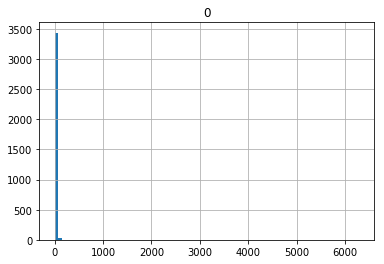

In [55]:
lengths.hist(bins=seq_lim)

# Well the plot cements our earlier inference, most of the sequences are indeed in <= 23 tokens per sentence range
## Let's limit the tokens to ~4 times the 75% of data, the other sequences
## i.e., 24 to 80 should have enough information for the larger sentences/tokens to give us enough information to decide the class of the sentence

# Limiting tokens to seq_lim, i.e., we are compressing the data, it is a lossy compression, similar to how a FLAC is compresses to MP3, the sounds are the same you may miss out on the quality a bit but it is not noticable to most users/ users with lower quality audio equipment.
## We run the inference one again with this crude data transformation

In [57]:
x_train = [el[0:seq_lim] for el in x_train]
num_tokens = [len(tokens) for tokens in x_train]

In [58]:
lengths = pd.DataFrame(data=num_tokens)

In [59]:
lengths.head()

,0
0,10
1,9
2,6
3,24
4,7


In [60]:
lengths.describe()

,0
count,3464.000000
mean,16.866917
std,12.527160
min,1.000000
25%,8.000000
50%,13.000000
75%,23.000000
max,80.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000E46568EC18>]],
      dtype=object)

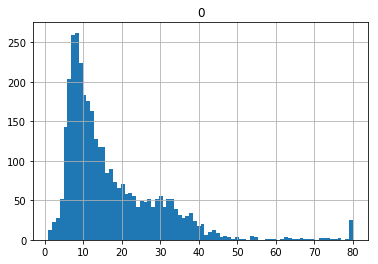

In [61]:
lengths.hist(bins=seq_lim)

# We see significant improvement in the standard deviation of the lengths
## Only about 30 sequences are >= 80 tokens, seems like a good enough compression with less loss. The are probably better ways to compress but this is the best I could think of for now

In [62]:
data['text'] = x_train

In [63]:
ones = data.loc[data['category'] == 1]
zeroes =  data.loc[data['category'] == 0]
ones.describe()

,category
count,116.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


# The data set is imbalanced, We balance the data set in a crude manner by only taking the same number of both class data to train the classifier

In [64]:
t_zeroes = zeroes.sample(n=116, replace=False, random_state=1)
frames = [ones, t_zeroes]
data_balanced = pd.concat(frames)
train, test = train_test_split(data_balanced, test_size=0.2)
data_x_train = data_balanced['text']
data_y_train = data_balanced['category']

In [65]:
x_train , y_train = train['text'], train['category']
x_test , y_test = test['text'], test['category']

In [23]:
print("Train-set size: ", len(x_train))
print("Test-set size:  ", len(x_test))

Train-set size:  185
Test-set size:   47


In [24]:
max_tokens = seq_lim

# Pre pad the sequence to make them equal length to feed the classifier

In [25]:
pad = 'pre'

In [26]:
x_train_pad = pad_sequences(x_train, maxlen=max_tokens,
                            padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test, maxlen=max_tokens,
                           padding=pad, truncating=pad)
data_x_train_pad = pad_sequences(data_x_train, maxlen=max_tokens,
                           padding=pad, truncating=pad)

In [27]:
embedding_size = seq_lim
max_features = seq_lim
epochs = 50
modelh5 = 'HaptikGRUClassifier'
loadmodelh5 = 'HaptikGRUClassifier-best'

# The model is pretty simple, embedding layers, followed by GRU layers, binary crossentropy is the loss function, we use adam optimizer and we observe the accuracy

In [28]:
try:
    model = load_model(loadmodelh5 + '.h5')
    print('Model loaded successfully')
except IOError:
    print('Building the model for the first time')
    model = Sequential()
    model.add(Embedding(input_dim=max_features,
                        output_dim=128,
                        input_length=seq_lim,
                        name='layer_embedding'))
    model.add(GRU(units=128, return_sequences=True))
    model.add(GRU(units=8))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
savebestmodel = ModelCheckpoint(modelh5 + '-best.h5', monitor='loss', verbose=0, save_best_only=True)

Building the model for the first time


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 80, 128)           10240     
_________________________________________________________________
gru_1 (GRU)                  (None, 80, 128)           98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 3288      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 112,225
Trainable params: 112,225
Non-trainable params: 0
_________________________________________________________________


In [30]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=epochs, batch_size=256, callbacks=[savebestmodel])

Train on 175 samples, validate on 10 samples
Epoch 1/50
175/175 [==============================] - 9s 50ms/step - loss: 0.6933 - acc: 0.2000 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/50
175/175 [==============================] - 1s 5ms/step - loss: 0.6925 - acc: 0.5257 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 3/50
175/175 [==============================] - 1s 5ms/step - loss: 0.6915 - acc: 0.5257 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 4/50
175/175 [==============================] - 1s 7ms/step - loss: 0.6905 - acc: 0.5257 - val_loss: 0.6918 - val_acc: 0.5000
Epoch 5/50
175/175 [==============================] - 1s 8ms/step - loss: 0.6892 - acc: 0.5543 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 6/50
175/175 [==============================] - 1s 7ms/step - loss: 0.6878 - acc: 0.5543 - val_loss: 0.6902 - val_acc: 0.5000
Epoch 7/50
175/175 [==============================] - 1s 5ms/step - loss: 0.6860 - acc: 0.5543 - val_loss: 0.6889 - val_acc: 0.5000
Epoch 8/50
175/175 [==========

In [31]:
%%time
result = model.evaluate(x_test_pad, y_test, batch_size=256)

47/47 [==============================] - 0s 4ms/step
Wall time: 202 ms


In [32]:
y_true, y_prob = y_train, model.predict(x_train_pad, batch_size=512)
y_pred = y_prob >= 0.5
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.74      0.80        90
          1       0.79      0.89      0.84        95

avg / total       0.83      0.82      0.82       185



In [33]:
y_true, y_prob = y_test, model.predict(x_test_pad, batch_size=512)
y_pred = y_prob >= 0.5
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.77      0.85        26
          1       0.77      0.95      0.85        21

avg / total       0.87      0.85      0.85        47



# F1-Score of 0.81 on training set and 0.85 on test set is a pretty good score, given that we have limited knowledge of the input data

In [70]:
%%time
model.fit(data_x_train_pad, data_y_train,
          validation_split=0.1, epochs=15, batch_size=256, callbacks=[savebestmodel])

Train on 208 samples, validate on 24 samples
Epoch 1/15
208/208 [==============================] - 1s 5ms/step - loss: 0.3583 - acc: 0.8702 - val_loss: 0.7272 - val_acc: 0.7083
Epoch 2/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3569 - acc: 0.8702 - val_loss: 0.7185 - val_acc: 0.7083
Epoch 3/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3558 - acc: 0.8702 - val_loss: 0.7102 - val_acc: 0.7083
Epoch 4/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3548 - acc: 0.8606 - val_loss: 0.7025 - val_acc: 0.7083
Epoch 5/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3539 - acc: 0.8606 - val_loss: 0.6960 - val_acc: 0.7083
Epoch 6/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3531 - acc: 0.8654 - val_loss: 0.6913 - val_acc: 0.7083
Epoch 7/15
208/208 [==============================] - 1s 5ms/step - loss: 0.3523 - acc: 0.8654 - val_loss: 0.6890 - val_acc: 0.7083
Epoch 8/15
208/208 [===========

In [119]:
y_true, y_prob = data_y_train, model.predict(data_x_train_pad, batch_size=512)
y_pred = y_prob >= 0.5
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.81      0.85       116
          1       0.83      0.90      0.86       116

avg / total       0.86      0.85      0.85       232



# Training on all the data for a few more epoachs, our F1-Score is pretty stable

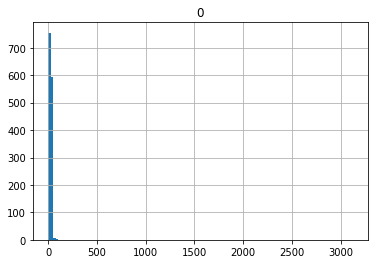

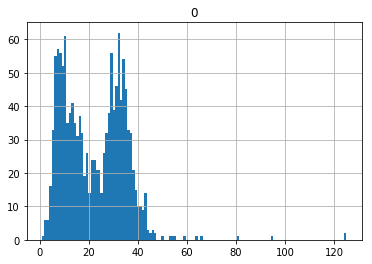

In [120]:
data = pd.read_csv('test.csv')

data.head()

ids = data['id']

data.drop(columns='id', inplace=True)

x_train = [el.split(' ') for el in data['text']]

num_tokens = [len(tokens) for tokens in x_train]

lengths = pd.DataFrame(data=num_tokens)

lengths.head()

lengths.describe()

lengths.hist(bins=125)

x_train = [el[0:125] for el in x_train]

num_tokens = [len(tokens) for tokens in x_train]

lengths = pd.DataFrame(data=num_tokens)

lengths.head()

lengths.describe()

lengths.hist(bins=125)

data['text'] = x_train

# The test set distribution is different from the training set, this would cause the test set results to be of lower accuracy

In [121]:
data.head()

,text
0,"[2705, 4888, 5050, 5815, 2472, 5157, 652, 2117..."
1,"[389, 4978, 315, 5178, 513, 5249, 5853, 3267, ..."
2,"[4478, 4231, 4858, 2638, 4231, 867, 371, 686, ..."
3,"[3015, 1911, 112, 3905, 825, 337, 315, 1693, 4..."
4,"[5136, 3918, 5153, 2023, 3091, 4159, 315, 3711..."


In [122]:
pad = 'pre'
x_test_pad = pad_sequences(data['text'], maxlen=max_tokens,
                           padding=pad, truncating=pad)

# I've made an error above, the "truncating=pad" would lead to [45:125] being considered as the sequence for the longer sequences but in training [0:80] was being considered.
# Given the longer sequences are very few, I don't think it would cause and major change is results even if this is fixed.
# For the smaller sequence there wold be no effects

In [123]:
y_prob = model.predict(x_test_pad, batch_size=512)
y_pred = y_prob >= 0.5

In [124]:
y_pred = y_pred.astype(int)

In [125]:
res = pd.DataFrame(data=ids)

In [126]:
res.head()

,id
0,3729
1,3732
2,3761
3,5
4,7


In [127]:
res['category'] = y_pred

In [128]:
res.to_csv('submission.csv', index=False)

In [129]:
print(y_pred)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [83]:
data_x_train_pad

array([[   0,    0,    0, ..., 1280, 2402, 2408],
       [   0,    0,    0, ...,  819, 5773,  332],
       [   0,    0,    0, ..., 1940, 3708, 3872],
       ...,
       [   0,    0,    0, ...,    0,    0, 7513],
       [   0,    0,    0, ..., 1543, 2734, 3078],
       [   0,    0,    0, ..., 4677, 5620, 3078]])

In [85]:
data_x_train_pad.shape

(232, 80)

In [86]:
x_test_pad.shape

(1360, 80)

# We got results of ~ 0.78 / 0.79 via skillenza's report for the above type of models
# Given that the distributions of the test set is different and we have nearly 80% predictability for our model, we include our predicted results as true results and run the model again for 15 epoachs

In [113]:
new_train_data = np.concatenate((data_x_train_pad, x_test_pad), axis=0)

In [114]:
new_train_data.shape

(1592, 80)

In [115]:
data_y_train.shape

(232,)

In [116]:
y_pred.shape

(1360, 1)

In [117]:
new_train_y = np.concatenate((np.array(data_y_train).reshape(232,1), y_pred), axis=0)

In [118]:
%%time
model.fit(new_train_data, new_train_y,
          validation_split=0.1, epochs=15, batch_size=256, callbacks=[savebestmodel])

Train on 1432 samples, validate on 160 samples
Epoch 1/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1496 - acc: 0.9532 - val_loss: 0.0680 - val_acc: 1.0000
Epoch 2/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1428 - acc: 0.9609 - val_loss: 0.0699 - val_acc: 0.9750
Epoch 3/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1319 - acc: 0.9588 - val_loss: 0.0821 - val_acc: 0.9812
Epoch 4/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1389 - acc: 0.9539 - val_loss: 0.0716 - val_acc: 1.0000
Epoch 5/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1248 - acc: 0.9707 - val_loss: 0.0783 - val_acc: 0.9937
Epoch 6/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1245 - acc: 0.9749 - val_loss: 0.0735 - val_acc: 0.9937
Epoch 7/15
1432/1432 [==============================] - 5s 3ms/step - loss: 0.1225 - acc: 0.9735 - val_loss: 0.0606 - val_acc: 1.0000
Epoch 8/15
1432

In [ ]:
y_prob = model.predict(x_test_pad, batch_size=512)
y_pred = y_prob >= 0.5
y_pred = y_pred.astype(int)
res = pd.DataFrame(data=ids)
res['category'] = y_pred
res.to_csv('submission.csv', index=False)

# This gives us the extra 1 to 2% boost in result accuracy

# Summary
## Things that could have been tried
<ol>
    <li>Different way to compress data</li>
    <li>Other RNN networks like LSTM's</li>
    <li>Have a different model for greater than 80 sequences examples</li>
    <li>Different architectures</li>
    <li>Ensembles models for the various models we build</li>
</ol>

### It was a nice challenge, You can check my other works at https://git.io/fjf20
### Thank you